In [2]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [6]:
data_path = 'https://raw.githubusercontent.com/karencfisher/hotel-reviews/main/data/reviews_sample.csv'
df_reviews = pd.read_csv(data_path)
df_reviews.drop(columns=['Unnamed: 0'], inplace=True)

,Content,average_score,sentiment
0,basic great location visited hotel birthday tr...,3.285714,0
1,beds best reading latest reviews think may bed...,2.571429,0
2,disappointment booked hotel january midapril s...,2.428571,0
3,never stay langland never stay langland sure c...,1.714286,0
4,rooms created equal although requested 2nd flo...,3.000000,0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_reviews['Content'],
                                                    df_reviews['sentiment'],
                                                    test_size=0.1)
x_train.shape, y_test.shape

((31609,), (3513,))

In [11]:
vocab_size = 10000
embed_dim = 64
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_text = tokenizer.texts_to_sequences(x_train)
x_train_text = pad_sequences(x_train_text, padding='post')

x_test_text = tokenizer.texts_to_sequences(x_test)
x_test_text = pad_sequences(x_test_text, padding='post')


In [12]:
model = Sequential([Embedding(vocab_size, embed_dim, mask_zero=True),
                    Bidirectional(LSTM(embed_dim, dropout=0.20)),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')])

opt = Adam(learning_rate=2e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________


In [14]:
stopping = EarlyStopping(monitor='val_accuracy', 
                         patience=3, 
                         restore_best_weights=True)

history = model.fit(x_train_text, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test_text, y_test),
                    callbacks=[stopping])

Epoch 1/30
 79/988 [=>............................] - ETA: 16:13 - loss: 0.6927 - accuracy: 0.5388

KeyboardInterrupt: 

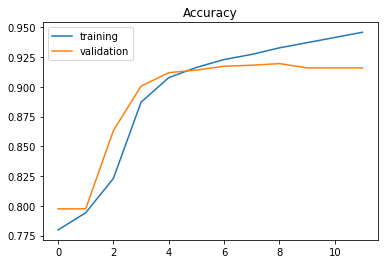

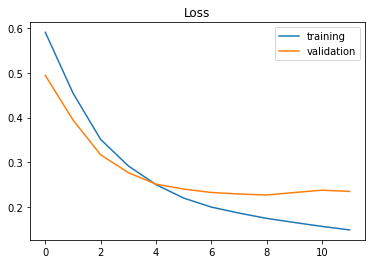

,train_loss,train_accuracy,validation_loss,validation_accuracy,variance
learning_rate_1.5e-5,0.266697,0.905553,0.274425,0.909991,-0.007729
learning_rate_2e-5,0.164545,0.937469,0.226417,0.919442,-0.061872


In [113]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label ='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label ='validation')
plt.legend()
plt.title('Loss')
plt.show()


In [105]:
pred_y = model.predict(x_test_text, verbose=1)
pred_y = pred_y > 0.5

70/70 [==============================] - 3s 49ms/step


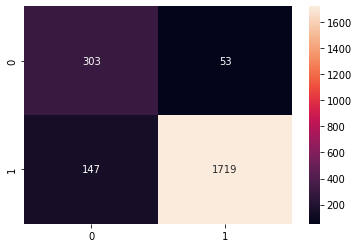

In [106]:
cf = confusion_matrix(pred_y, y_test)
sns.heatmap(cf, annot=True, fmt='d');

In [108]:
print(classification_report(pred_y, y_test, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.67      0.85      0.75       356
    Positive       0.97      0.92      0.95      1866

    accuracy                           0.91      2222
   macro avg       0.82      0.89      0.85      2222
weighted avg       0.92      0.91      0.91      2222



Compare with baseline: the probability of being accurate if one randomly guesses one or zero for each example, which is 66.89%.

91% accuracy beats the baseline, by 21%.